In [15]:
#data import
from skimage.io import imread
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#gpu import
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

#model imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.resnet import ResNet101

In [4]:
#setup GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

Num GPUs Available:  1


In [5]:
#image processing function
IMG_H = int(170/3)
IMG_W = int(432/3)
#IMG_D = 3
def preprocessImg(img):
    img = img[70:240,0:432] #170,432,3
    h,w,d = img.shape
    img = cv2.resize(img,(int(w/3),int(h/3)))
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = img/255.0
    return img

In [8]:
#read in track pandas data TRACK
#1. read in full data
steeringData = pd.read_csv('newData/labeled_data.csv',header=None)
steeringData = steeringData[:71000]
#2. drop name of frame column
steeringDataNoImg = steeringData.drop(steeringData.columns[0:2],axis=1)
#steeringDataNoImg


#loadin in straight data STRAIGHT
#read in pandas data
#1. read in full data
straightData = pd.read_csv('straightData/labeled_data.csv',header=None)
#2. drop name of frame column
straightDataNoImg = straightData.drop(straightData.columns[0:2],axis=1)
#straightDataNoImg

In [9]:
#read in images to array + preprocess TRACK
dataDir = 'newData/frames/'
dataFormat = '.jpg'
dataImages = []
for i in steeringData[0]:
    img = imread('{}{}{}'.format(dataDir,i,dataFormat), as_gray=False)
    img = preprocessImg(img)
    dataImages.append(img)
    
#read in images to array + preprocess STRIAGHT
straightDataDir = 'straightData/frames/'
dataFormat = '.jpg'
straightDataImages = []
for i in straightData[0]:
    img = imread('{}{}{}'.format(straightDataDir,i,dataFormat), as_gray=False)
    img = preprocessImg(img)
    straightDataImages.append(img)

In [10]:
#images to numpy array TRACK
X = np.array(dataImages).reshape(-1,IMG_H,IMG_W,3)
steeringDataNoImg

#images to numpy array STRAIGHT
Z = np.array(straightDataImages).reshape(-1,IMG_H,IMG_W,3)
straightDataNoImg

,2
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
22656,0.0
22657,0.0
22658,0.0
22659,0.0


In [11]:
#JOINING DATA

#FRAMES
finalFrames = np.concatenate((X,Z))
finalFrames

array([[[[0.49411765, 0.50980392, 0.59215686],
         [0.45882353, 0.4627451 , 0.53333333],
         [0.40784314, 0.38823529, 0.44313725],
         ...,
         [0.15294118, 0.16078431, 0.2       ],
         [0.1254902 , 0.12941176, 0.16470588],
         [0.12156863, 0.12156863, 0.15686275]],

        [[0.50196078, 0.51764706, 0.6       ],
         [0.46666667, 0.4745098 , 0.54509804],
         [0.41568627, 0.39607843, 0.45098039],
         ...,
         [0.1372549 , 0.14117647, 0.17254902],
         [0.1254902 , 0.1254902 , 0.16078431],
         [0.1254902 , 0.12156863, 0.15686275]],

        [[0.52941176, 0.55686275, 0.63529412],
         [0.49803922, 0.50980392, 0.57647059],
         [0.44705882, 0.43529412, 0.47843137],
         ...,
         [0.12156863, 0.11764706, 0.14509804],
         [0.12941176, 0.1254902 , 0.15686275],
         [0.13333333, 0.12941176, 0.15686275]],

        ...,

        [[0.56078431, 0.50980392, 0.5254902 ],
         [0.55686275, 0.50588235, 0.51764706]

In [12]:
#STEERING
#finalSteering = pd.concat([steeringDataNoImg,straightDataNoImg])
finalSteering = steeringDataNoImg.append(straightDataNoImg)
for i in finalSteering:
    print(finalSteering)
finalSteering.to_csv('testing.csv',index=False)

         2
0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
...    ...
22656  0.0
22657  0.0
22658  0.0
22659  0.0
22660  0.0

[93661 rows x 1 columns]


In [16]:
resnet = ResNet101(weights='imagenet', include_top=False,input_shape=X.shape[1:])

for layer in resnet.layers[:-4]:
    layer.trainable = False
    
def nvidia_model():
  model = tf.keras.Sequential()
  model.add(resnet)
    
  model.add(Dropout(0.5))
  
  model.add(Flatten())
  
  model.add(Dense(100, activation='elu'))
  model.add(Dropout(0.5))

  model.add(Dense(50, activation='elu'))
  model.add(Dropout(0.5))


  model.add(Dense(10, activation='elu'))
  model.add(Dropout(0.5))


  model.add(Dense(1))
  
  optimizer = Adam(lr=1e-3)
  model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
  return model
resnet1 = nvidia_model()

hist = resnet1.fit(finalFrames,finalSteering,epochs=25,batch_size=128, validation_split=0.2,verbose=1,shuffle=1)

171450368/171446536 [==============================] - 64s 0us/step
Epoch 1/25
586/586 [==============================] - 71s 113ms/step - loss: 4.7110 - accuracy: 0.0475 - val_loss: 0.2852 - val_accuracy: 0.4676
Epoch 2/25
586/586 [==============================] - 50s 86ms/step - loss: 0.6519 - accuracy: 0.0587 - val_loss: 0.3911 - val_accuracy: 0.4676
Epoch 3/25
586/586 [==============================] - 50s 86ms/step - loss: 0.3003 - accuracy: 0.0602 - val_loss: 0.4880 - val_accuracy: 0.4676
Epoch 4/25
586/586 [==============================] - 50s 86ms/step - loss: 0.1720 - accuracy: 0.0594 - val_loss: 0.4914 - val_accuracy: 0.4676
Epoch 5/25
586/586 [==============================] - 50s 86ms/step - loss: 0.1262 - accuracy: 0.0603 - val_loss: 0.5131 - val_accuracy: 0.4676
Epoch 6/25
586/586 [==============================] - 50s 86ms/step - loss: 0.1075 - accuracy: 0.0598 - val_loss: 0.5355 - val_accuracy: 0.4676
Epoch 7/25
586/586 [==============================] - 50s 86ms/step

Text(0.5, 0, 'Epoch')

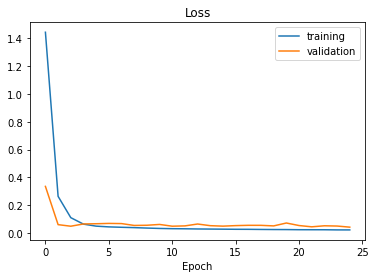

In [14]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [ ]:
resnet1.save('2CombinedModel.h5')

In [17]:
resnet.summary()

Model: "resnet101"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 56, 144, 3)] 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 62, 150, 3)   0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 28, 72, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 28, 72, 64)   256         conv1_conv[0][0]                 
__________________________________________________________________________________________

conv4_block10_1_bn (BatchNormal (None, 4, 9, 256)    1024        conv4_block10_1_conv[0][0]       
__________________________________________________________________________________________________
conv4_block10_1_relu (Activatio (None, 4, 9, 256)    0           conv4_block10_1_bn[0][0]         
__________________________________________________________________________________________________
conv4_block10_2_conv (Conv2D)   (None, 4, 9, 256)    590080      conv4_block10_1_relu[0][0]       
__________________________________________________________________________________________________
conv4_block10_2_bn (BatchNormal (None, 4, 9, 256)    1024        conv4_block10_2_conv[0][0]       
__________________________________________________________________________________________________
conv4_block10_2_relu (Activatio (None, 4, 9, 256)    0           conv4_block10_2_bn[0][0]         
__________________________________________________________________________________________________
conv4_bloc